<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Text Analytics Functions using 'teradatagenai' Package
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial'><b>Introduction:</b></p>
<p style = 'font-size:16px;font-family:Arial'><b>teradatagenai</b> is Teradata Python package for Generative-AI functions.<br>
The following outlines a general workflow for ‘teradatagenai’. Users can utilize Python to perform a range of text analytics tasks on data stored in Vantage. This can be achieved by leveraging Teradata's Bring Your Own Large Language Model offering or by using In-DB TextAnalytics AI functions to access models provided by AWS, Azure, and GCP.

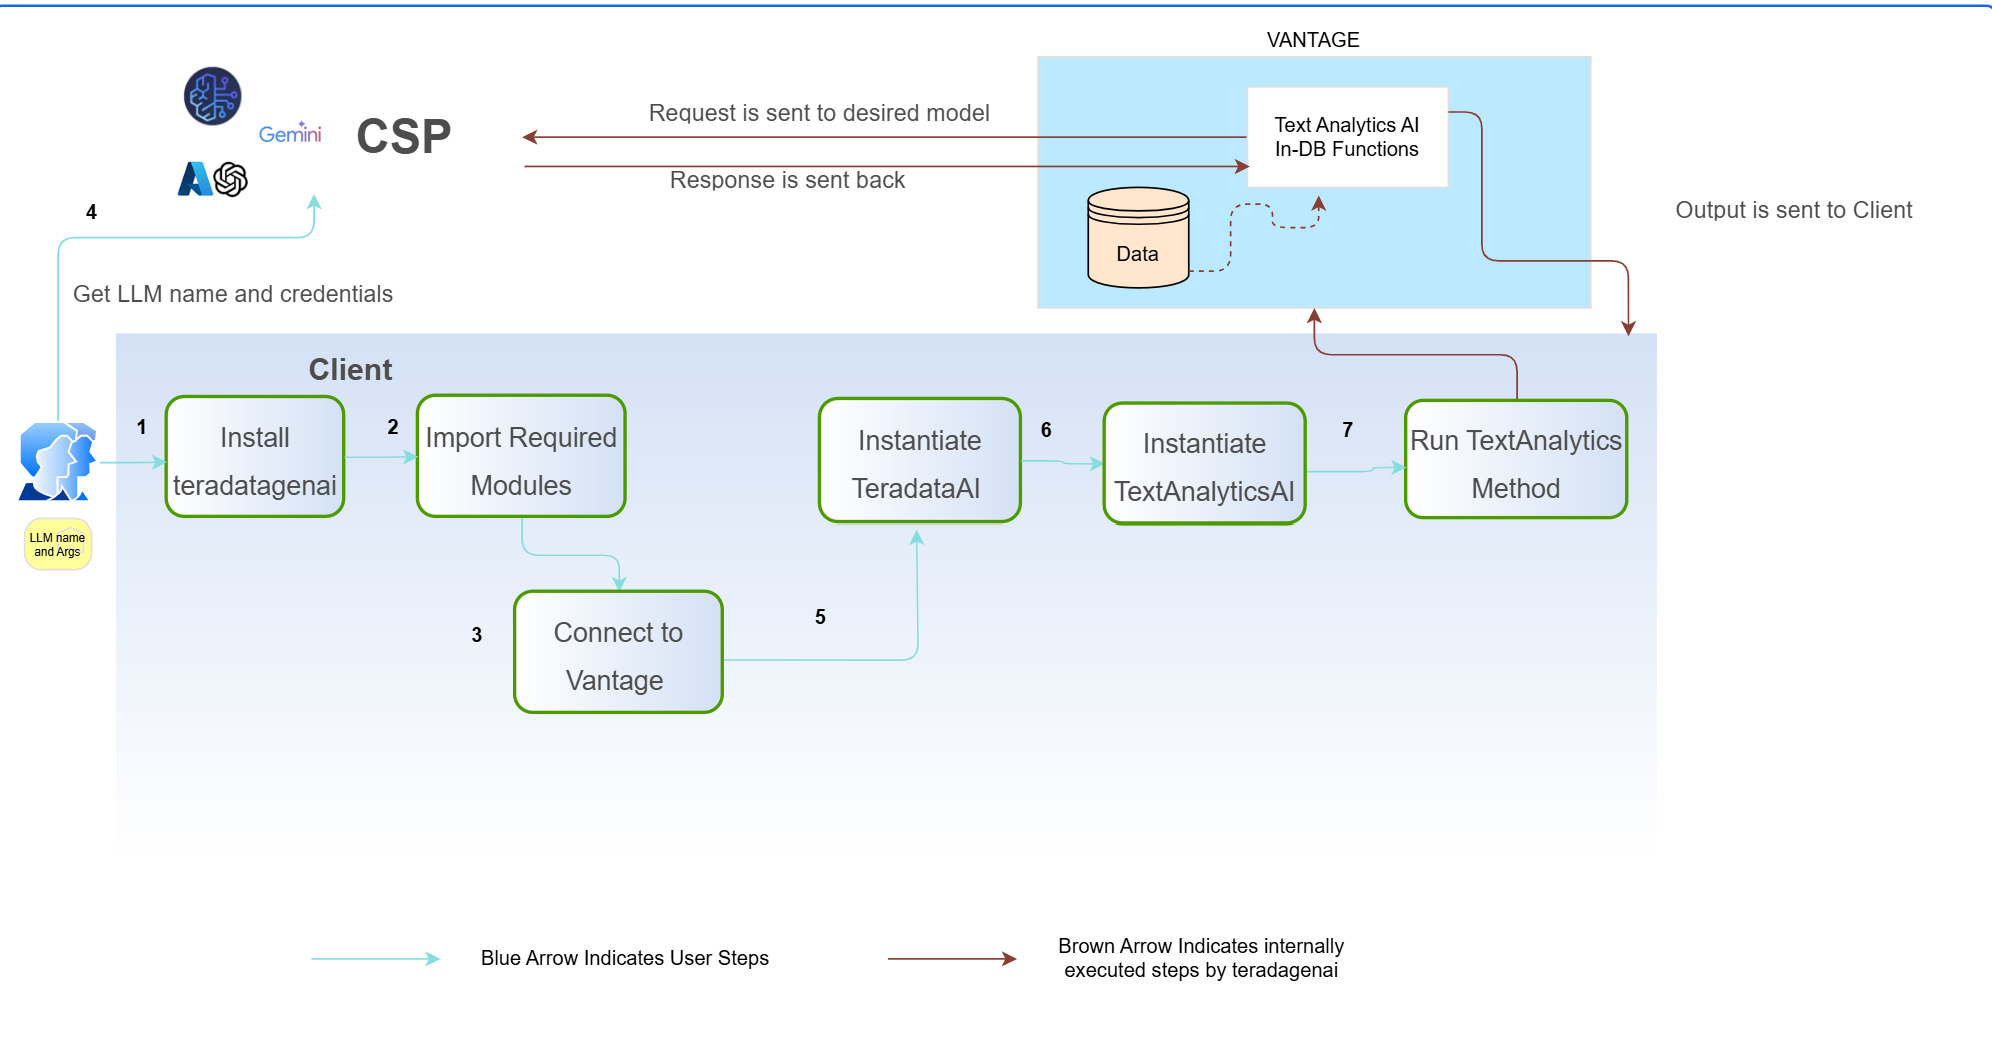

<p style = 'font-size:16px;font-family:Arial'><i>Disclaimer</i><br>
The sample code (“Sample Code”) provided is not covered by any Teradata agreements. Please be aware that Teradata has no control over the model responses to such sample code and such response may vary. The use of the model by Teradata is strictly for demonstration purposes and does not constitute any form of certification or endorsement. The sample code is provided “AS IS” and any express or implied warranties, including the implied warranties of merchantability and fitness for a particular purpose, are disclaimed. In no event shall Teradata be liable for any direct, indirect, incidental, special, exemplary, or consequential damages (including, but not limited to, procurement of substitute goods or services; loss of use, data, or profits; or business interruption) sustained by you or a third party, however caused and on any theory of liability, whether in contract, strict liability, or tort arising in any way out of the use of this sample code, even if advised of the possibility of such damage.

<hr style='height:2px;border:none'>
<b style = 'font-size:20px;font-family:Arial'>1. Configure the environment</b>

<p style = 'font-size:16px;font-family:Arial'> For this notebook to run properly we will need teradataml version 20.00.00.05 or greater and teradatagenai version 20.00.00.1 or greater; below command will check the versions and install required versions</p>

In [ ]:
!pip show teradataml || pip install teradataml==20.00.00.05

In [ ]:
!pip show teradatagenai || pip install teradatagenai==20.00.00.1

<div class="alert alert-block alert-info">
    <p style='font-size:16px;font-family:Arial'><i><b>Note:</b>If the above commands install the modules please restart the kernel after executing those lines to bring the installed libraries into memory. The simplest way to restart the Kernel is by typing zero zero: <b>0 0</b></i></p>
</div>

In [ ]:
from getpass import getpass
# Required imports
from teradatagenai import TextAnalyticsAI, TeradataAI, load_data
from teradataml import create_context, DataFrame,dotenv_values,execute_sql,db_drop_table,remove_context
import os

# Suppress warnings
import warnings

warnings.filterwarnings('ignore')
display.suppress_vantage_runtime_warnings = True


<hr style="height:2px;border:none">
<p style = 'font-size:20px;font-family:Arial'><b>2. Connect to VantageCloud Lake</b></p>
<p style = 'font-size:16px;font-family:Arial'>Connect to VantageCloud using `create_context` from the teradataml Python library. Input your connection details, including the host, username, password and Analytic Compute Group name.</p>

In [ ]:
print("Checking if this environment is ready to connect to VantageCloud Lake...")

if os.path.exists("/home/jovyan/JupyterLabRoot/VantageCloud_Lake/.config/.env"):
    print("Your environment parameter file exist.  Please proceed with this use case.")
    # Load all the variables from the .env file into a dictionary
    env_vars = dotenv_values("/home/jovyan/JupyterLabRoot/VantageCloud_Lake/.config/.env")
    # Create the Context
    eng = create_context(host=env_vars.get("host"), username=env_vars.get("username"), password=env_vars.get("my_variable"))
    execute_sql('''SET query_band='DEMO=VCL_GettingStarted_VectorStore.ipynb;' UPDATE FOR SESSION;''')
    print("Connected to VantageCloud Lake with:", eng)
else:
    print("Your environment has not been prepared for connecting to VantageCloud Lake.")
    print("Please contact the support team.")

<hr style="height:2px;border:none;">
<p style="font-size:20px;font-family:Arial"><b>3. Loading the data </b></p>
<p style="font-size:16px;font-family:Arial">We will be loading the sample data using the 'load_data()' helper function.</p>

In [ ]:
load_data('employee', 'employee_data')
data = DataFrame('employee_data')
data

In [ ]:
data.shape

In [ ]:
load_data('question', 'question_data')
question = DataFrame('question_data')
question

In [ ]:
question.shape

In [ ]:
load_data('context', 'context_data')
context = DataFrame('context_data')
context

In [ ]:
context.shape

<hr style="height:2px;border:none;">
<p style="font-size:20px;font-family:Arial"><b>4. Setting up TeradataAI to access AWS Bedrock Model </b></p>
<p style="font-size:16px;font-family:Arial">This section describes how to instantiate the `TeradataAI` class to set up the environment and initialize the LLM endpoint.<br>Users can provide the required authorization information in four different ways:
    <ol style="font-size:16px;font-family:Arial">
        <li>Explicitly pass the authorization information to each argument of the function.</li>
        <li>Set the environment variables related to the authorization arguments.</li>
        <li>Supply the authorization information via a configuration file.</li>
        <li>Pass an existing database authorization object containing the credentials using the authorization parameter.</li>
        </ol>
            </p>

In [ ]:
# Set the environment variables related to the authorization arguments.
os.environ['AWS_ACCESS_KEY_ID'] = getpass("Enter AWS Access Key ID: ")
os.environ['AWS_SECRET_ACCESS_KEY'] = getpass("Enter AWS Secret Access Key: ")
os.environ['AWS_DEFAULT_REGION'] = getpass("Enter AWS Default Region: ")

In [ ]:
# Instantiate the TeradataAI class with the AWS Bedrock model.
llm_aws = TeradataAI(api_type="aws",
                     model_name="anthropic.claude-v2"
                     )

<hr style="height:2px;border:none;">
<p style="font-size:20px;font-family:Arial"><b>5. Setting up TextAnalyticsAI to Perform Various Text Analytics Tasks </b></p>
<p style="font-size:16px;font-family:Arial">This section describes how to instantiate the `TextAnalyticsAI` class to access a variety of text analytics methods.<br><b>Key Notes</b>:
    <ul style="font-size:16px;font-family:Arial">
        <li><b>General Method Arguments:</b>
            <ul style="font-size:16px;font-family:Arial">
                <li><b>column:</b> Specifies the name of the column to be used.
                    <ul><li>Type:str</li></ul>
                </li>
                <li><b>data:</b> pecifies the teradataml.DataFrame that includes the column specified by the column argument.<ul><li>Type:teradataml.DataFrame</li></ul></li>
            </ul>
        </li>
        <li><b>Optional Parameters:</b>
            <ul style="font-size:16px;font-family:Arial">
                <li><b>persist:</b> Specifies whether to persist the output in permanent tables.
                    <ul><li>Type:bool</li>
                        <li>Default:False</li>  
                    </ul>
                </li>
                <li><b>accumulate:</b> Specifies the name(s) of input teradataml.DataFrame column(s) to copy to the output. By default, all input columns are copied to the output.
                    <ul><li>Type:str or list of str  </li>
                    </ul>
                </li>
                <li><b>volatile:</b> Specifies whether to store the results in a volatile table.
                   <ul><li>Type:bool</li>
                        <li>Default:False</li>  
                    </ul>
                </li>
            </ul>
        </li>
        <li><b>Additional Arguments (**kwargs) :</b>
            <ul style="font-size:16px;font-family:Arial">
                <li><b>column:</b> Methods accept additional arguments that can be passed as part of **kwargs. For more details, refer to the user guide.
                 </li>
                  </ul>
        </li>            
                </ul>
        </p>

In [ ]:
# Instantiate the TextAnalyticsAI class with the AWS Bedrock model.
obj = TextAnalyticsAI(llm=llm_aws)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.1 Sentiment Analysis</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the analyze_sentiment() function provided by TextAnalyticsAI. Based on the text analysis, the sentiment can be positive, negative, or neutral.</p>

In [ ]:
# Analyze the sentiment of the reviews in the employee data.
obj.analyze_sentiment(column="reviews",data=data,accumulate='reviews')

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.2 Text Classification</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the classify() function provided by TextAnalyticsAI. This function is used to classify the given text.</p>

In [ ]:
# Classify the articles in the employee data into multiple categories.
obj.classify(column="articles",data=data, accumulate="articles", labels=["sports", "politics", "entertainment", "technology"], multi_label=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.3 Text Summarization</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the summarize() function provided by TextAnalyticsAI. This function is used to generate a concise summary of a given text.</p>

In [ ]:
# Summarize the articles in the employee data.
obj.summarize(column="articles",data=data,accumulate='articles',volatile=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.4 Key Phrase Extraction</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the extract_key_phrases() function provided by TextAnalyticsAI. This function is used to extract key phrases from a given text. These key phrases can provide a quick understanding of the main concepts in the text.</p>

In [ ]:
# Extract key phrases from the articles in the employee data.
obj.extract_key_phrases(column="articles",data=data,accumulate='employee_name:articles',volatile=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.5 Masking Personal Information Identification (PII) Entities</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the mask_pii() function provided by TextAnalyticsAI. This function is used to mask Personal Identifiable Information (PII) entities within a given text. This can be particularly useful when you want to protect sensitive data in your text.</p>

In [ ]:
# Mask PII (Personally Identifiable Information) in the employee data.
obj.mask_pii(column="employee_data",data=data,accumulate='employee_data',volatile=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.6 Recognizing Personal Information Identification (PII) Entities</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll delve into the recognize_pii_entities() function provided by TextAnalyticsAI. This function is designed to identify Personal Identifiable Information (PII) entities within text data. PII entities can include sensitive data like 'names', 'addresses', 'social security numbers', 'email addresses', 'phone numbers', etc.</p>

In [ ]:
# Recognize PII entities in the employee data.
obj.recognize_pii_entities(column="employee_data",data=data,accumulate='employee_data',volatile=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.7 Language Translation</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the `translate()` function provided by TextAnalyticsAI. This function is used to translate the language of a given text.</p>

In [ ]:
# Translate the quotes in the employee data to the default language English.
obj.translate(column="quotes",data=data,accumulate='quotes',volatile=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.8 Language Detection</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the detect_language() function provided by TextAnalyticsAI. This function is used to identify the language of a given text.</p>

In [ ]:
# Detect the language of the quotes in the employee data 
obj.detect_language(column="quotes",data=data,volatile=True)

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.9 Entity Recognition</b>
<p style="font-size:16px;font-family:Arial"> In this section, we delve into the recognize_entities() function, provided by TextAnalyticsAI. This function is designed to identify a wide range of entities within text data. These entities can include 'people', 'places', 'products', 'organizations', 'date/time', 'quantities', 'percentages', 'currencies', and 'names'.</p>

In [ ]:
# Recognize entities in the articles in the employee data.
obj.recognize_entities(column="articles",data=data,accumulate='articles')

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.10 Asking the LLM</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the ask() function provided by TextAnalyticsAI. This function is used to ask questions to the LLM based on the given context.</p>

In [ ]:
# Asking questions to the LLM using context data.
# data_partition_column: 'id' and context_partition_column: 'id' are used to partition the data and context tables.
# Prompt is used to provide a template for the question and data.
obj.ask(column="text_data", data=question,
        context=context, context_column='text_data',
        data_partition_column='id', context_partition_column='id',
        prompt='''Provide an answer to the question using data as
        information relevant to the question.
        \nQuestion: #QUESTION# \n Data: #DATA#''',
        data_position='#DATA#',
        question_position='#QUESTION#')

<hr style="height:1px;border:none;">
<p style="font-size:18px;font-family:Arial"><b>5.11 Generating Embeddings</b>
<p style="font-size:16px;font-family:Arial"> In this section, we'll explore the embeddings() function provided by TextAnalyticsAI.</p>

In [ ]:
# Instantiate the TeradataAI class with the AWS Bedrock model.
llm_embedding = TeradataAI(api_type="aws",                      
               model_name="amazon.titan-embed-text-v2:0",
               region="us-west-2")

In [ ]:
# Instantiate the TextAnalyticsAI class with the embedding model.
obj_embeddings = TextAnalyticsAI(llm=llm_embedding)

In [ ]:
# Generate embeddings for the articles in the employee data.
obj_embeddings.embeddings(column="articles",data=data,accumulate='articles',output_format='VARCHAR')

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>6. Cleanup</b></p>
<p style = 'font-size:18px;font-family:Arial'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial'>We need to clean up our work tables to prevent errors next time.</p>

In [ ]:
tables = ['employee_data', 'question_data','context_data']

# Loop through the list of tables and execute the drop table command for each table
for table in tables:
    try:
        db_drop_table(table_name=table)
    except:
        pass

In [ ]:
remove_context()

<footer style="padding-bottom:35px; border-bottom:3px solid #91A0Ab">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
        <div style="float:right;">
            <div style="float:left; margin-top:14px">
                Copyright © Teradata Corporation - 2025. All Rights Reserved
        </div>
    </div>
</footer>